# DM-27813 Crowded Fields to Zooniverse

In [1]:
import functools
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import os
import pandas as pd
import sqlite3
import json
import astropy.visualization as aviz

import panoptes_client

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

import lsst.geom
from lsst.ip.diffim import GetCoaddAsTemplateTask


# local to ap_pipe-notebooks
import plotLightcurve
import apdbPlots

In [3]:
# The gen2 butler repos containing the templates and difference images, respectively.
#parent = "/project/sullivan/saha/cwcoadds_processed"
#REPO = '/project/sullivan/saha/ap_pipe/cw/'

In [2]:
# this set uses the 2015 data as templates since they are better seeing
parent = "/project/sullivan/saha/cwcoadds_2015"
REPO = '/project/sullivan/saha/ap_pipe/cw_2013/'

In [3]:
# The URL where the output files can be accessed by zooniverse.
#url_root = "https://lsst.ncsa.illinois.edu/~parejkoj/zooniverse/"
url_root = "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/"

# The path to write the PNG and manifest files to.
output_path = "/scratch/ebellm/zooniverse/"

In [4]:
connection = sqlite3.connect(f'{REPO}/association.db')

In [5]:
butler = dafPersist.Butler(inputs=[REPO, parent])

First we want to get a random subset of DIASources from the APDB.

In [6]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
#ds_sample = pd.read_sql_query('select * from DiaSource LIMIT 100;', connection)
ds_sample = pd.read_sql_query('select * from DiaSource ORDER BY RANDOM() LIMIT 200;', connection)

CPU times: user 7.58 s, sys: 10.1 s, total: 17.7 s
Wall time: 2min 42s


In [7]:
ds_sample.flags

0      25165824
1             0
2      41943040
3             0
4          1320
         ...   
195           0
196    25169320
197    25165824
198    25166616
199    41943040
Name: flags, Length: 200, dtype: int64

In [8]:
apdbPlots.addVisitCcdToSrcTable(ds_sample)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,extendedness,spuriousness,flags,pixelId,filterName,filterId,isDipole,bboxSize,ccd,visit
0,89968642749378735,20947457,95977731493205765,0,0,0,None,56450.104736,270.545103,None,...,None,None,25165824,0,g,1,0,13,57,209474
1,89971138125372023,20948038,90453462952708948,0,0,0,None,56450.115570,273.404229,None,...,None,None,0,0,g,1,1,29,38,209480
2,89997711088045934,20954225,89997711088045934,0,0,0,None,56450.242038,271.374426,None,...,None,None,41943040,0,g,1,1,77,25,209542
3,88377709553529478,20577039,92827295672182637,0,0,0,None,56424.383398,270.088987,None,...,None,None,0,0,g,1,0,27,39,205770
4,90290614972729511,21022422,90123111248183405,0,0,0,None,56452.240531,272.556602,None,...,None,None,1320,0,g,1,0,13,22,210224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,90120491318128352,20982812,90120491318128352,0,0,0,None,56451.191290,271.641150,None,...,None,None,0,0,g,1,0,40,12,209828
196,88379809792533059,20577528,88379809792533059,0,0,0,None,56424.393234,272.183355,None,...,None,None,25169320,0,g,1,0,15,28,205775
197,88277937463242865,20553809,88231122319711314,0,0,0,None,56423.398364,272.125692,None,...,None,None,25165824,0,i,3,1,72,09,205538
198,96153829447318255,22387558,90453548852057509,0,0,0,None,56510.120020,272.608165,None,...,None,None,25166616,0,g,1,1,50,58,223875


## Get calexp, template, and difference cutouts for each source

In [9]:
# @functools.lru_cache()
# NOTE: dataId is a dict, which is not hashable thus not cacheable
def get_images(dataId):
    exposure = butler.get('calexp', dataId)
    difference = butler.get('deepDiff_differenceExp', dataId)
    template = butler.get('deepDiff_warpedExp', dataId)
    return exposure, difference, template

def get_cutouts(dataId, center, size=lsst.geom.Extent2I(30, 30)):
    """Return a cutout for this dataId at the given source location."""
    # TODO: We can make this a lot faster by loading the images for every "ccd/visit" combo,
    # TODO: and then making the cutouts at each source that lies on that ccd.
    exposure, difference, template = get_images(dataId)
    return exposure.getCutout(center, size), difference.getCutout(center, size), template.getCutout(center, size)

In [10]:
# an example dataId and center for playing with making a single image.
i=50
dataId={'ccd': int(ds_sample['ccd'][i]), 'visit': int(ds_sample['visit'][i])}
center=lsst.geom.SpherePoint(ds_sample['ra'][i], ds_sample['decl'][i], lsst.geom.degrees)
exposure, difference, template = get_cutouts(dataId, center)

## Plot the images

In [11]:
def plot_cutout(science, difference, template, output=None):
    """Plot the cutouts for a source in one image.
    """
    Qst=15 #Q for Science and Template
    sst=4 #Stretch for Science and Template
    Qd=5 #Q for Difference
    sd=50 #Stretch for Difference
    asinst=0.01
    asind=0.7

    def do_one(ax, data, name):
        interval = aviz.ZScaleInterval()

        if name == 'Difference':
            norm = aviz.ImageNormalize(data,  stretch=aviz.LinearStretch())
        else:
            norm = aviz.ImageNormalize(data, interval=interval, stretch=aviz.AsinhStretch(a=0.01))
        ax.imshow(data, cmap=cm.bone, interpolation="none")
        ax.axis('off')
        ax.set_title(name)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_one(ax1, template.image.array, "Template")
    do_one(ax2, science.image.array, "Science")
    do_one(ax3, difference.image.array, "Difference")
    plt.tight_layout()

    if output is not None:
        plt.savefig(output, bbox_inches="tight")
        plt.close()

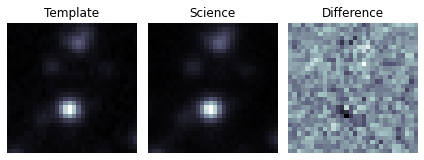

In [12]:
plot_cutout(exposure, difference, template)

## Generate manifest information for upload to Zooniverse

In [13]:
def make_manifest(data, url_root):
    output = pd.DataFrame([])
    output['uuid'] = data['diaSourceId']
    output['location:1'] = ds_sample.apply(lambda x: f"{url_root}{x['diaSourceId']}.png", axis=1)
    output['metadata:diaSourceId'] = data['diaSourceId']
    return output

## Make plots for every source

In [14]:
# TODO: as currently written, this is going to be *very* slow because it re-loads the images for every source.
for index,source in ds_sample.iterrows():
    center = lsst.geom.SpherePoint(source['ra'], source['decl'], lsst.geom.degrees)
    dataId = {'ccd': int(source['ccd']), 'visit': int(source['visit'])}
    exposure, difference, template = get_cutouts(dataId, center)
    filename = f"{source['diaSourceId']}.png"
    plot_cutout(exposure, difference, template, output=f"{output_path}{filename}")

## Submit data to Panoptes

In [15]:
manifest = make_manifest(ds_sample, url_root)
manifest.to_csv(os.path.join(output_path, "manifest.csv"))
manifest.to_json(os.path.join(output_path, "manifest.json"))

In [5]:
client = panoptes_client.Panoptes.connect(login="interactive")

Enter your Zooniverse credentials...


Username:  ebellm
 ······························


In [6]:
project = panoptes_client.Project.find(slug='ebellm/alert-production-zoo')

In [7]:
project.id

'11152'

In [8]:
print([(ss.id, ss.display_name) for ss in project.links.subject_sets])

[('80863', 'HiTS'), ('81026', 'HSC-COSMOS'), ('90418', 'saha')]


In [19]:
# make a new subject set
subject_set = panoptes_client.SubjectSet()

subject_set.links.project = project
subject_set.display_name = 'saha'

subject_set.save()

{'subject_sets': [{'id': '90418',
   'display_name': 'saha',
   'set_member_subjects_count': 0,
   'metadata': {},
   'created_at': '2020-12-15T09:51:55.915Z',
   'updated_at': '2020-12-15T09:51:55.950Z',
   'href': '/subject_sets/90418',
   'links': {'project': '11152', 'workflows': [], 'subjects': []}}],
 'links': {'subject_sets.project': {'href': '/projects/{subject_sets.project}',
   'type': 'projects'},
  'subject_sets.workflows': {'href': '/workflows?subject_set_id={subject_sets.id}',
   'type': 'workflows'}},
 'meta': {'subject_sets': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_sets',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_sets'}}}

In [20]:
project.reload()